In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


In [ ]:
from tensorflow import keras
from keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import imageio

import os
import re
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

"""
## Constants and hyperparameters
"""

batch_size = 12
num_channels = 1
num_classes = 10
# image size 284x476
image_size_x = 284
image_size_y = 476
latent_dim = 120

In [ ]:
"""
## Loading the our dataset and preprocessing it
"""
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# We'll use all the available examples from both the training and test
# sets.
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

data_path = './night_time'
all_files = [f for f in os.listdir(data_path)]
all_files = sorted(all_files, key=natural_keys)
split_index = int(len(all_files) * 0.9)
train_data, test_data = all_files[:split_index], all_files[split_index:]

x_train = []
y_train = []

for index, i in enumerate(train_data):
    img = Image.open(data_path + '/' + i)
    gray_img = img.convert('L')
    matrix = np.array(gray_img)
    x_train.append(matrix)
    # training label
    y_train.append(index // 12)

x_test = []
y_test = []

for index, i in enumerate(test_data):
    # testing dataset
    img = Image.open(data_path + '/' + i)
    gray_img = img.convert('L')
    matrix = np.array(gray_img)
    x_test.append(matrix)

    # testing label
    y_test.append(index // 12)

all_digits = np.concatenate([x_train, x_test])

all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0

all_digits = np.reshape(all_digits, (-1, 284, 476, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)
print(len(y_train), len(y_test))



# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

108 12
Shape of training images: (120, 284, 476, 1)
Shape of training labels: (120, 10)


In [ ]:
"""
## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).
"""

generator_in_channels =  num_classes + latent_dim
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

"""
## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).
"""

discriminator = keras.Sequential(
        [
            layers.InputLayer(input_shape=(image_size_x, image_size_y, discriminator_in_channels)),
            layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
    name='discriminator',
    )




generator = keras.Sequential(
        [
            keras.layers.InputLayer((generator_in_channels,)),
            layers.Dense(71 * 119 * 128),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((71, 119, 128)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
    name='generator',
    )





130 11


In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator,generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size_x * image_size_y]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size_x, image_size_y, num_classes)
        )
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, tf.cast(one_hot_labels, tf.float32)], axis=1
        )
        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
"""
## Training the Conditional GAN
"""
conditional_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

conditional_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)


conditional_gan.fit(dataset, epochs= 200)



Epoch 1/200
10/10 [==============================] - 4s 106ms/step - g_loss: 0.7650 - d_loss: 0.7264
Epoch 2/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7239 - d_loss: 0.6798
Epoch 3/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6966 - d_loss: 0.6708
Epoch 4/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6985 - d_loss: 0.6912
Epoch 5/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7416 - d_loss: 0.6979
Epoch 6/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6922 - d_loss: 0.7436
Epoch 7/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7496 - d_loss: 0.7338
Epoch 8/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7619 - d_loss: 0.6926
Epoch 9/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6870 - d_loss: 0.7416
Epoch 10/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7031 - d_lo

In [ ]:
conditional_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
conditional_gan.fit(dataset, epochs= 200)

Epoch 1/200
10/10 [==============================] - 4s 104ms/step - g_loss: 0.7224 - d_loss: 0.6934
Epoch 2/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7489 - d_loss: 0.7039
Epoch 3/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6739 - d_loss: 0.7012
Epoch 4/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7135 - d_loss: 0.6910
Epoch 5/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7669 - d_loss: 0.6799
Epoch 6/200
10/10 [==============================] - 1s 102ms/step - g_loss: 0.7112 - d_loss: 0.6875
Epoch 7/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6938 - d_loss: 0.6891
Epoch 8/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7320 - d_loss: 0.6976
Epoch 9/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.6763 - d_loss: 0.7133
Epoch 10/200
10/10 [==============================] - 1s 103ms/step - g_loss: 0.7127 - d_lo

In [ ]:
# Save the generator model
generator.save("generator_model_ep220.h5")

# Save the discriminator model
discriminator.save("discriminator_model_ep220.h5")

In [ ]:
from keras.models import load_model

# Load the generator model
loaded_generator = load_model("./generator_model_ep320.h5")

# Load the discriminator model
loaded_discriminator = load_model("./discriminator_model_ep320.h5")


3/3 [==============================] - 0s 45ms/step



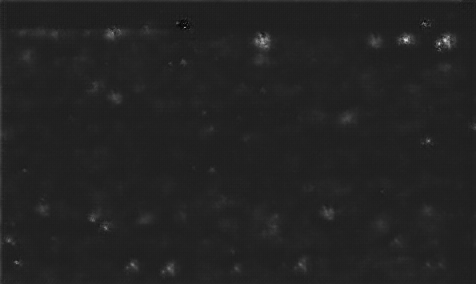

In [ ]:
"""
## Interpolating between classes with the trained generator
"""
conditional_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# We first extract the trained generator from our Conditiona GAN.
trained_gen = conditional_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 90  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
end_class = 9  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

"""
Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.
"""

fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (284, 476)).numpy().astype(np.uint8)
imageio.mimsave("animation_2.gif", converted_images, fps=1)
embed.embed_file("animation_2.gif")